## Final Project :  Optimizing Bank Marketing Campaigns: Predictive Analysis of Term Deposit Subscriptions

### Motivation & Objective



The Bank Marketing dataset from the UCI Machine Learning Repository contains information related to direct marketing campaigns conducted by a Portuguese banking institution. These campaigns were primarily carried out through phone calls, often requiring multiple contacts with the same client to determine if they would subscribe to a term deposit.

The dataset provides a rich source of information for analyzing and predicting customer behavior in the context of bank marketing. It includes various features such as customer demographics (age, job, marital status, education), financial indicators (balance, credit history), and campaign-related information (number of contacts, previous campaign outcomes). The primary objective of this dataset is to predict whether a client will subscribe to a term deposit based on these features.

My motivation for selecting this dataset for the final project stems from the increasing importance of data- driven marketing strategies in the financial sector. By analyzing this dataset, I aim to uncover patterns and insights that can help banks optimize their marketing campaigns and improve customer engagement. The main objective is to develop a predictive model that can accurately identify potential term deposit subscribers, thereby increasing the efficiency of marketing efforts and reducing costs.




Throughout this project, I intend to answer the following research questions:

1. Which features are the most influential predictors of term deposit subscriptions in the Bank Marketing dataset?

2. How does incorporating cyclical encoding for time-related features (month and day of week) impact the classification performance for term deposit subscriptions?



In [5]:
# ## Install these dependencies
# ! pip install xgboost
# ! pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 123.5 MB/s eta 0:00:00


In [ ]:
# !pip install -r requirements.txt

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn.over_sampling


from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [8]:
data=pd.read_csv('bank-additional-full.csv',sep=';')

In [9]:
data.shape

(41188, 21)

There are ~41K rows

There are ~21 columns

### Dataset Description

| Attribute Name | Description |
|----------------|-------------|
| age | Age of the client (numeric) |
| job | Type of job (categorical) |
| marital | Marital status (categorical) |
| education | Education level (categorical) |
| default | Has credit in default? (categorical: "yes","no") |
| balance | Average yearly balance, in euros (numeric) |
| housing | Has housing loan? (categorical: "yes","no") |
| loan | Has personal loan? (categorical: "yes","no") |
| contact | Contact communication type (categorical: "unknown","telephone","cellular") |
| day | Last contact day of the month (numeric) |
| month | Last contact month of year (categorical) |
| duration | Last contact duration, in seconds (numeric) |
| campaign | Number of contacts performed during this campaign and for this client (numeric) |
| pdays | Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |
| previous | Number of contacts performed before this campaign and for this client (numeric) |
| poutcome | Outcome of the previous marketing campaign (categorical: "unknown","other","failure","success") |
| y | Has the client subscribed a term deposit? (binary: "yes","no") - Target variable |

##### Removing duplicate rows

In [12]:
data=data[~data.duplicated()] #removing duplicate rows

In [13]:
data.shape

(41176, 21)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In a first look we can see that they are no unknowns, lets dig deeper using EDA

### EDA

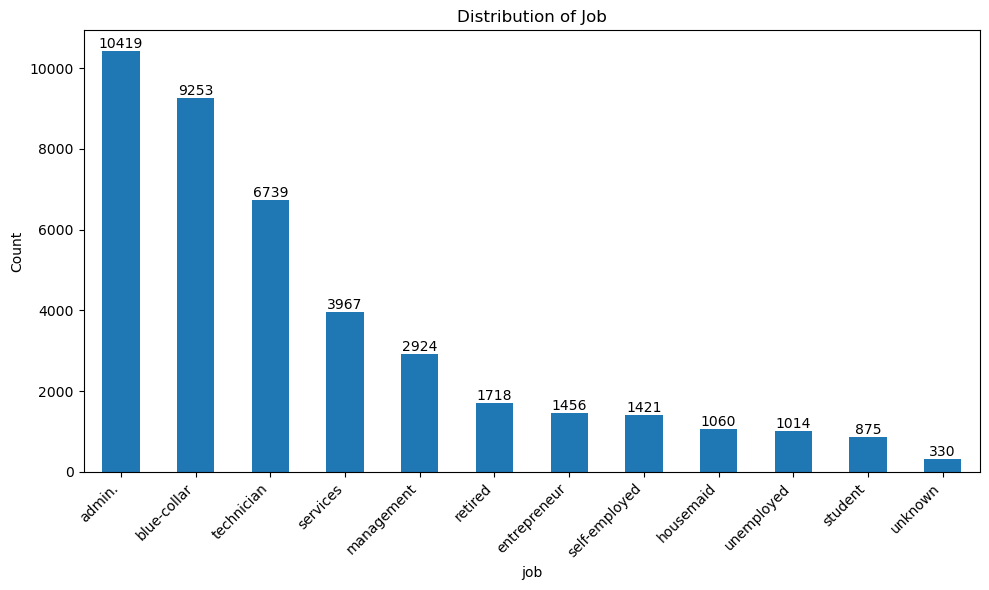

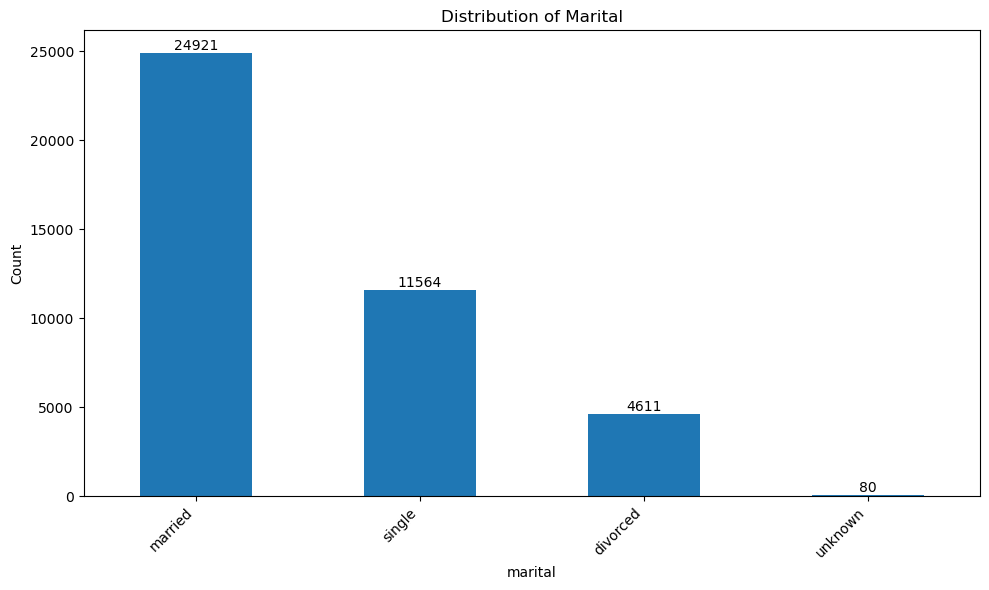

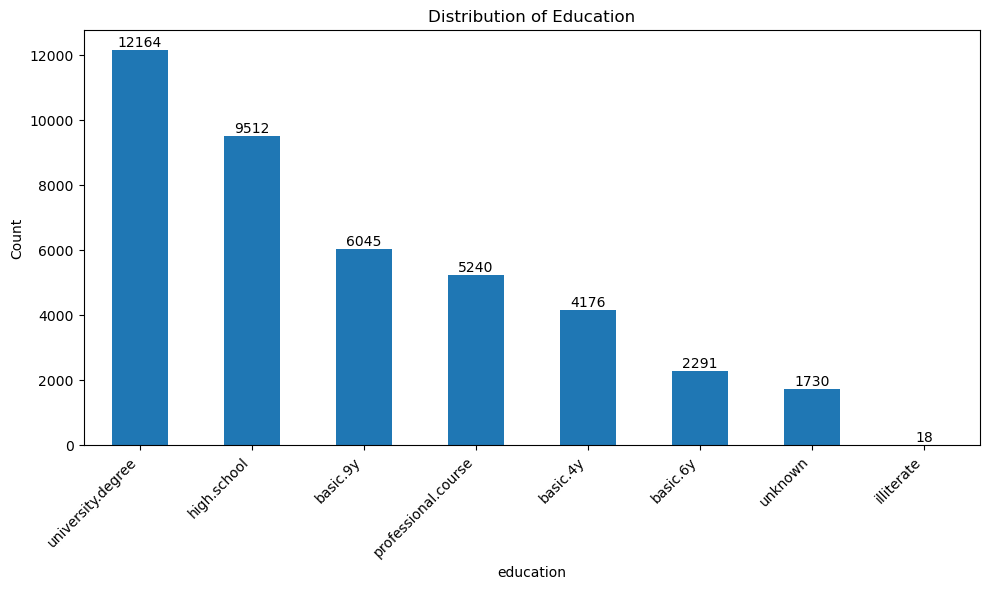

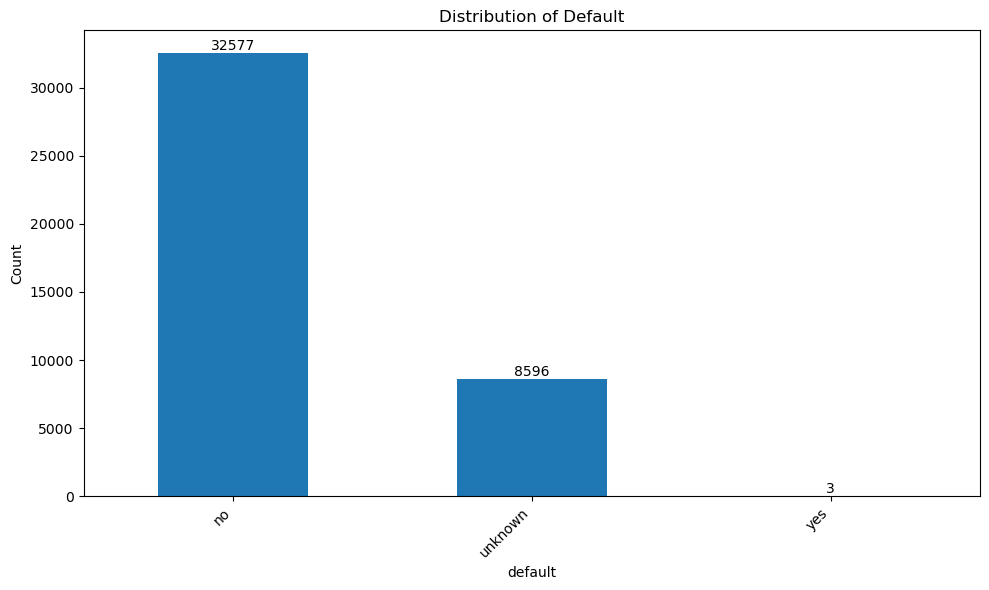

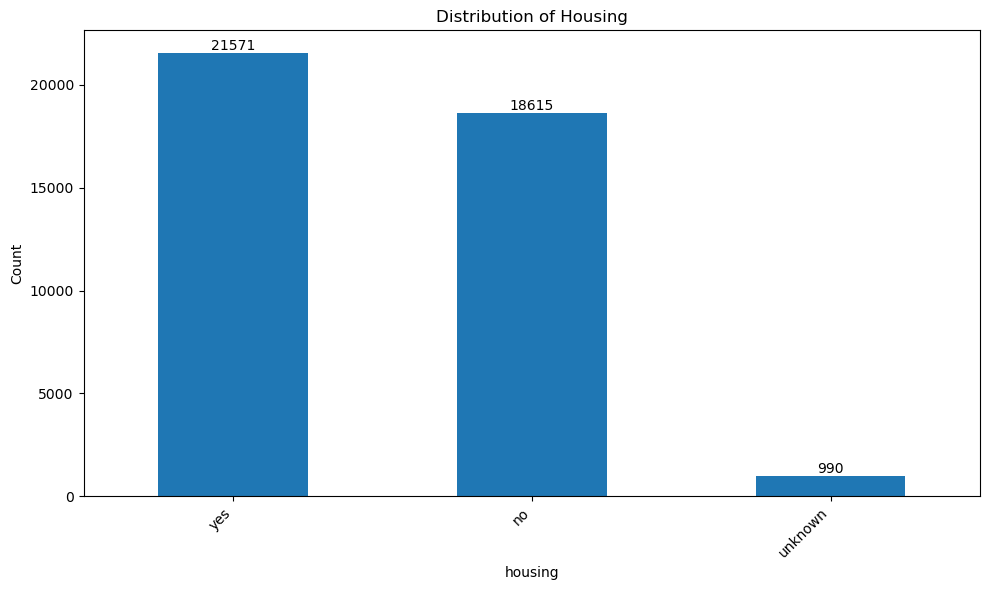

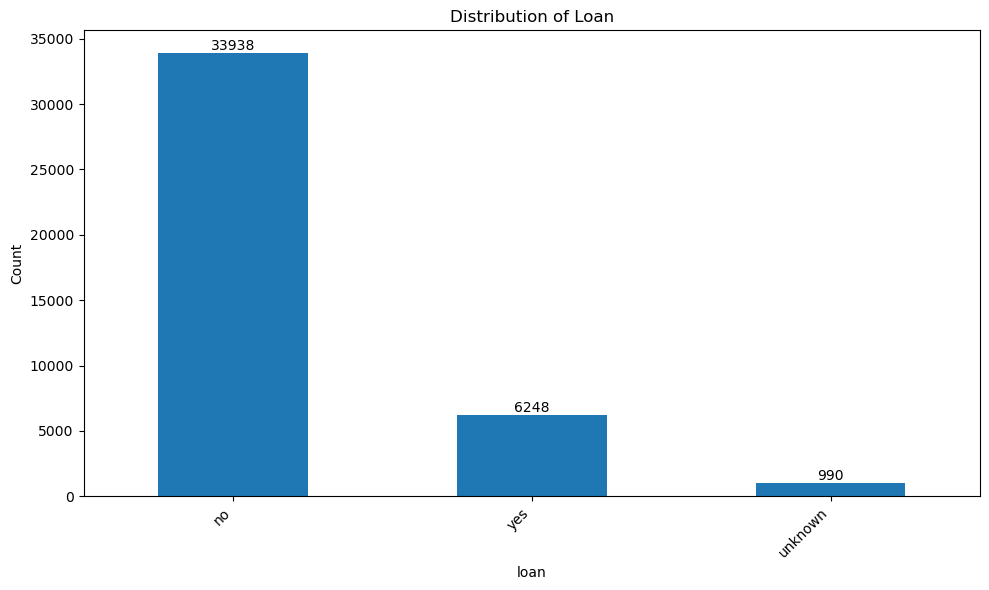

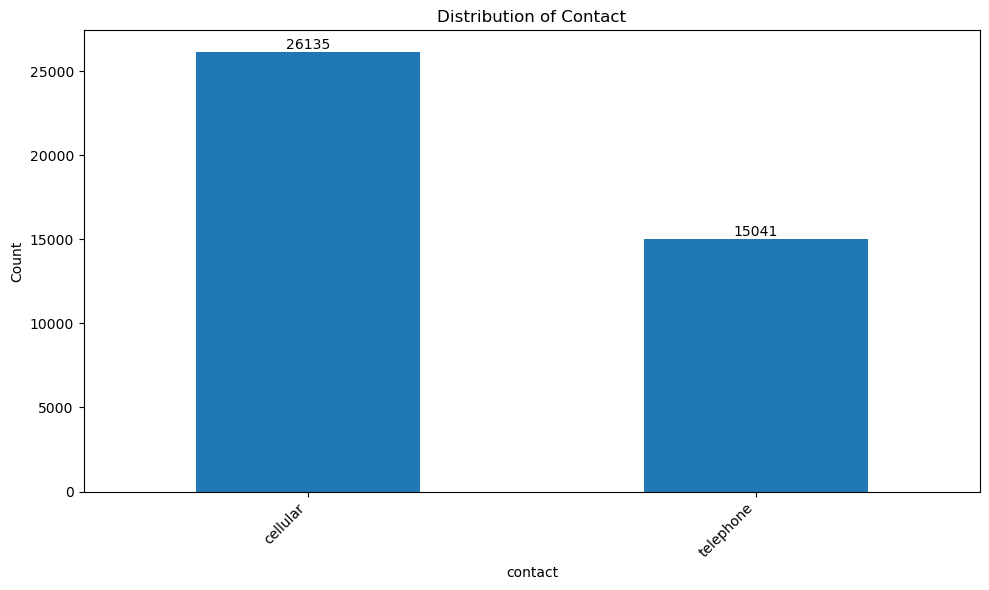

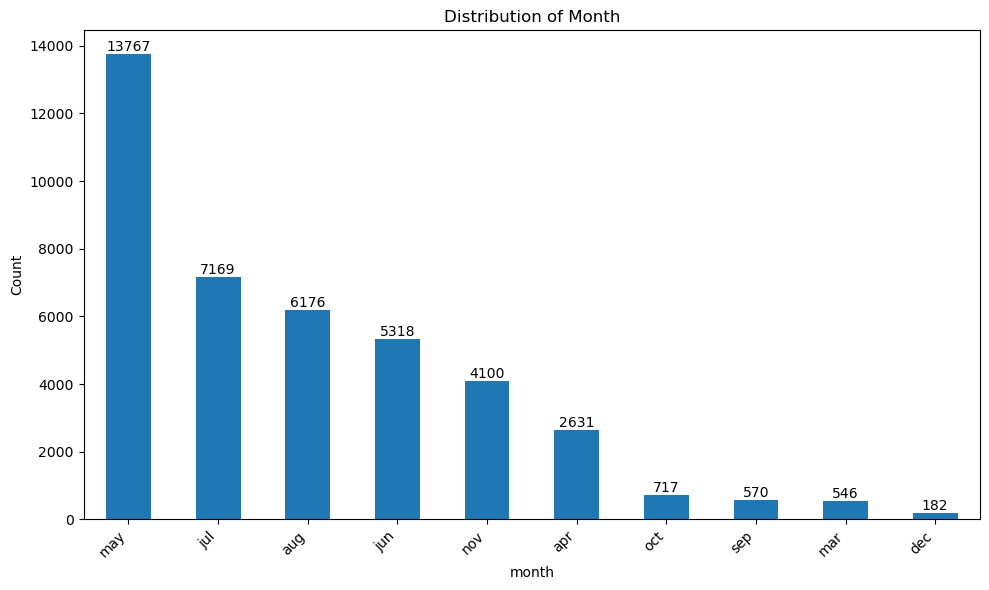

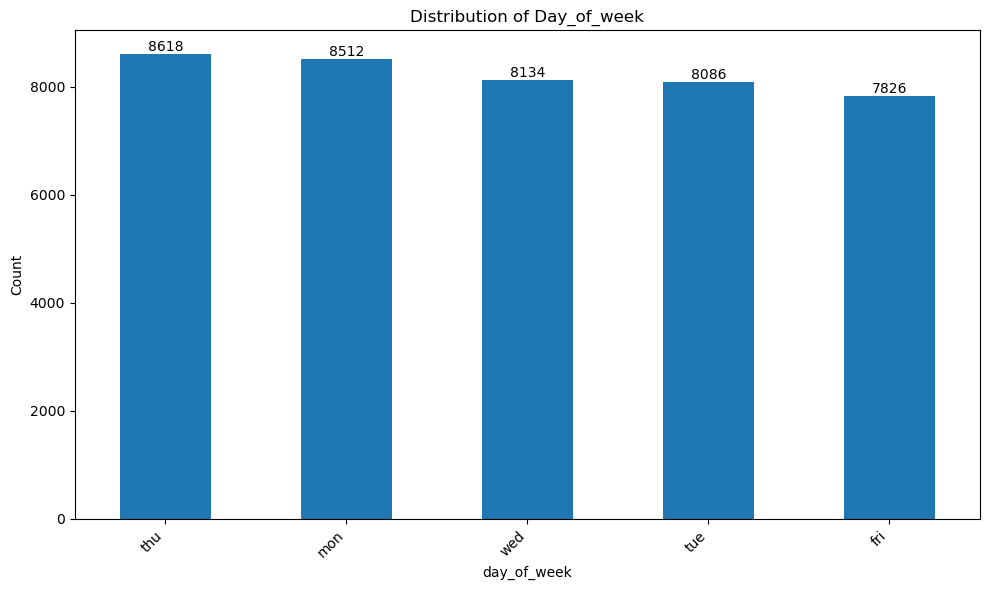

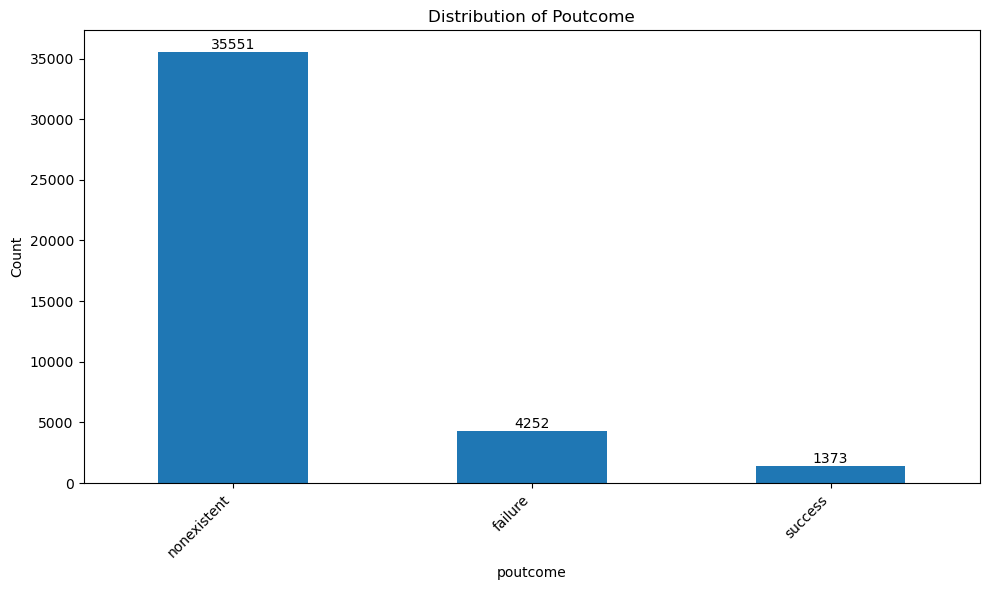

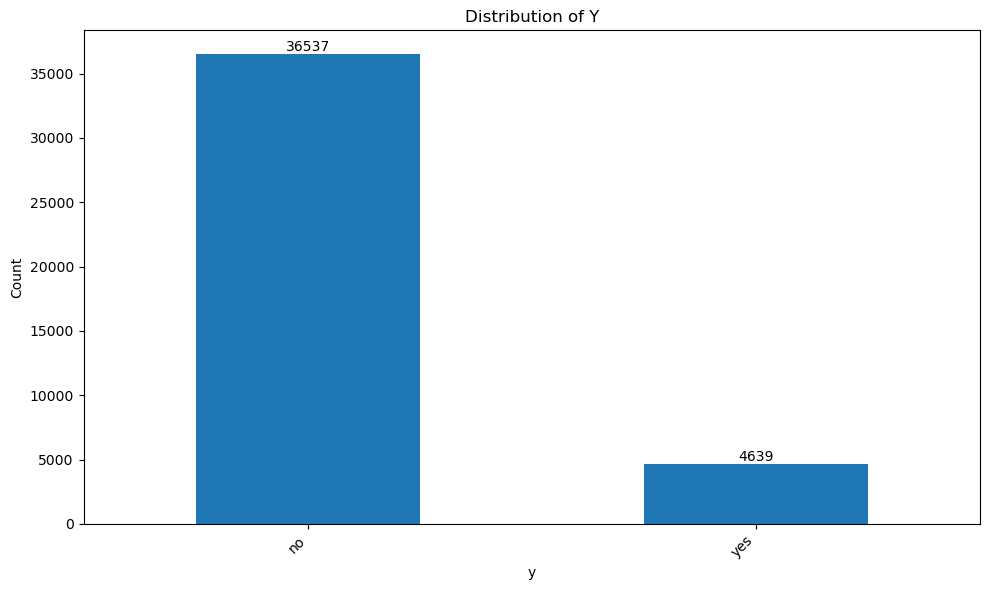

In [15]:
def plot_value_counts_with_labels(data, column, title, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    count_data = data[column].value_counts()
    bars = count_data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Adding count labels on top of each bar
    for bar in bars.patches:
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height(),
                 int(bar.get_height()),
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# List of non-numeric columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

# Create a plot for each categorical column
for column in categorical_columns:
    plot_value_counts_with_labels(data, column, f'Distribution of {column.capitalize()}')

There are some columns that have a class named unknown, it entirely depends whether we have to consider them as a new class or not. We should also make sure that are cardinality is not too high, dealing with cardinalty is important because if we are doing encoding and using something like one-hot, then this can lead to high-dimensionality.

In [16]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### EDA on numeric values in the dataset

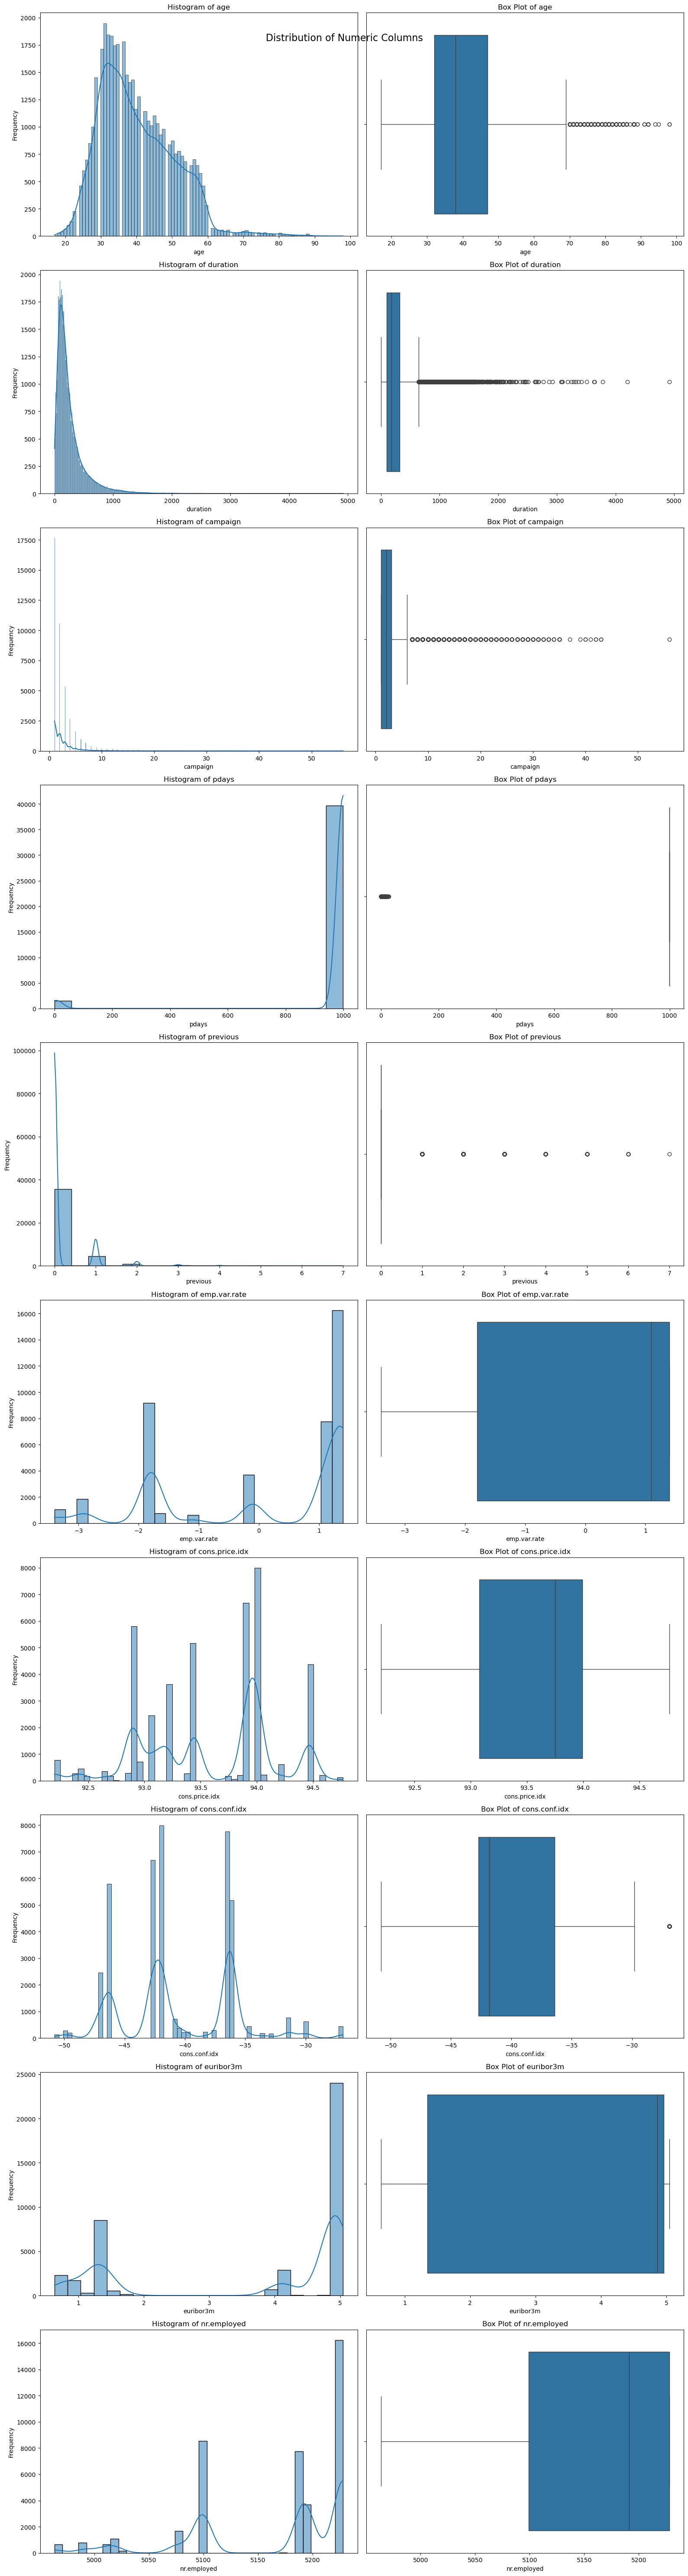

In [17]:
# Select numeric columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Set up the plot
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(16, 6*len(numeric_columns)))
fig.suptitle('Distribution of Numeric Columns', fontsize=16)

# Create histograms and box plots for each numeric column
for i, column in enumerate(numeric_columns):
    # Histogram
    sns.histplot(data[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(x=data[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {column}')
    axes[i, 1].set_xlabel(column)

plt.tight_layout()
plt.show()


In [18]:
## We can see a lot of unknowns in many columns, so lets just replace them with NaN
data.replace('unknown', pd.NA, inplace=True)

#### now lets see the actual number of unknowns in every column

In [30]:
for i in data.columns:
    data[i] = np.where(data[i] == "unknown", np.nan, data[i])
data.isna().sum()

age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

The default column has significant number of unknowns we can treat this as a seperate class. But, if we look at the distribution we see that, there are only 3 yes. I think dropping the entire column would be better since its binary and also we don't want bias.
The other columns have unknown values of < ~2%, we can just drop them. But, before dropping the default column, lets see how much dataloss we have after dropping all rows that have null values


In [25]:
data_dropped = data.dropna(subset=data.columns.difference(['default']))
data_dropped.shape

(38234, 21)

After dropping the NaN values from all columns except default, we have approx 38k rows, which is a reduction of ~7% of rows which isn't bad. Handling them all can lead to complications

here I'm combining all the various basic level of education to a single basic category

In [26]:
data_dropped['education'] = data_dropped['education'].replace(to_replace=r'basic.*', value='basic', regex=True)

In [27]:
data_dropped.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,<NA>,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


###  Feature Engineering and Selection

In [28]:
## Encoding
data_dropped['loan'].replace(to_replace='no', value=0, inplace=True)
data_dropped['loan'].replace(to_replace='yes',  value=1, inplace=True)
data_dropped['housing'].replace(to_replace='no', value=0, inplace=True)
data_dropped['housing'].replace(to_replace='yes',  value=1, inplace=True)

here we are dropping default columns and the columns we don't have a description about

In [29]:
# List of columns to drop
columns_to_drop = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'default']

# Drop the columns
data_dropped = data_dropped.drop(columns=columns_to_drop)

In [30]:
data_dropped.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')

### Cyclic Encoding for time-based-columns

In [32]:
# Map months and days to integers
months_dict = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 
               'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 
               'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}

days_dict = {'mon': 0, 'tue': 1, 'wed': 2, 
             'thu': 3, 'fri': 4, 
             # Assuming weekend handling if needed
             # Add more if Saturday and Sunday are included
            }

data_dropped['month'] = data_dropped['month'].map(months_dict)
data_dropped['day_of_week'] = data_dropped['day_of_week'].map(days_dict)

# One-hot encode specified columns
data_encoded = pd.get_dummies(data_dropped, columns=['job', 'marital', 'contact', 'poutcome'], drop_first=True)

# Label encode education
le = LabelEncoder()
data_encoded['education'] = le.fit_transform(data_encoded['education'])

# Cyclic encoding for month and day_of_week
data_encoded['month_sin'] = np.sin(2 * np.pi * data_encoded['month'] / 12)
data_encoded['month_cos'] = np.cos(2 * np.pi * data_encoded['month'] / 12)
data_encoded['day_sin'] = np.sin(2 * np.pi * data_encoded['day_of_week'] / 7)
data_encoded['day_cos'] = np.cos(2 * np.pi * data_encoded['day_of_week'] / 7)

# Drop original month and day_of_week if no longer needed
data_encoded.drop(columns=['month', 'day_of_week'], inplace=True)

# Display the first few rows of the encoded DataFrame
data_encoded.head()

,age,education,housing,loan,duration,campaign,pdays,previous,y,job_blue-collar,...,job_unemployed,marital_married,marital_single,contact_telephone,poutcome_nonexistent,poutcome_success,month_sin,month_cos,day_sin,day_cos
0,56,0,0,0,261,1,999,0,no,0,...,0,1,0,1,1,0,0.866025,-0.5,0.0,1.0
1,57,1,0,0,149,1,999,0,no,0,...,0,1,0,1,1,0,0.866025,-0.5,0.0,1.0
2,37,1,1,0,226,1,999,0,no,0,...,0,1,0,1,1,0,0.866025,-0.5,0.0,1.0
3,40,0,0,0,151,1,999,0,no,0,...,0,1,0,1,1,0,0.866025,-0.5,0.0,1.0
4,56,1,0,1,307,1,999,0,no,0,...,0,1,0,1,1,0,0.866025,-0.5,0.0,1.0


In [33]:
## Encode the target variable
data_encoded['y'].replace(to_replace='no', value=0, inplace=True)
data_encoded['y'].replace(to_replace='yes',  value=1, inplace=True)

### Spliiting the dataset first before scaling to avoid data leakage

In [34]:
# Select Features
feature = data_encoded.drop('y', axis=1)

# Select Target
target = data_encoded['y']

# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(feature,target,test_size=0.2,random_state=42)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (30587, 27)
Shape of testing feature: (7647, 27)
Shape of training label: (30587,)
Shape of training label: (7647,)


In [35]:
scaler=StandardScaler()
X_train =scaler.fit_transform(X_train)
X_test =scaler.transform(X_test)

Using SMOTE to deal with class imbalance

In [36]:
# smote
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_train, y_train = smote.fit_resample(X_train, y_train)

In [37]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}


### Model Development and Evaluation

In [38]:
# Building Random Forest model 
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state=0)
rf.fit(X_train, y_train)
# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])


Accuracy: 0.9036223355564273
Precision: 0.612184249628529
Recall: 0.46396396396396394
F1 Score: 0.5278667520819987
Area Under Curve: 0.8885663293120017
Confusion Matrix:
 [[6498  261]
 [ 476  412]]


In [39]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=0.1, objective='binary:logistic', random_state=0)

# Fit the model
xgb_model.fit(X_train, y_train)
# Evaluate the XGBoost model
xgb_eval = evaluate_model(xgb_model, X_test, y_test)

# Print results
print('Accuracy:', xgb_eval['acc'])
print('Precision:', xgb_eval['prec'])
print('Recall:', xgb_eval['rec'])
print('F1 Score:', xgb_eval['f1'])
print('Area Under Curve:', xgb_eval['auc'])
print('Confusion Matrix:\n', xgb_eval['cm'])

Accuracy: 0.8880606773898261
Precision: 0.5160965794768612
Recall: 0.5777027027027027
F1 Score: 0.5451647183846972
Area Under Curve: 0.8876869545977402
Confusion Matrix:
 [[6278  481]
 [ 375  513]]


### HYPERPARAMETER TUNING

#### Hyperparameter Tuning on RandomForest Classifer

In [42]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}


rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

rf_eval = evaluate_model(best_rf, X_test, y_test)

print('Best Parameters:', best_params)
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9050608081600627
Precision: 0.6082887700534759
Recall: 0.5123873873873874
F1 Score: 0.5562347188264058
Area Under Curve: 0.9217568933780652
Confusion Matrix:
 [[6466  293]
 [ 433  455]]


##### Hyperparameter Tuning on XGBoost

In [47]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(objective='binary:logistic', random_state=0, verbosity=0)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

xgb_eval = evaluate_model(best_xgb, X_test, y_test)

print('Best Parameters:', best_params)
print('Accuracy:', xgb_eval['acc'])
print('Precision:', xgb_eval['prec'])
print('Recall:', xgb_eval['rec'])
print('F1 Score:', xgb_eval['f1'])
print('Area Under Curve:', xgb_eval['auc'])
print('Confusion Matrix:\n', xgb_eval['cm'])


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.9062377402903099
Precision: 0.6169630642954856
Recall: 0.5078828828828829
F1 Score: 0.5571340333539222
Area Under Curve: 0.9268519518186629
Confusion Matrix:
 [[6479  280]
 [ 437  451]]


Based on the results, both Random Forest and XGBoost models showed improvement after hyperparameter tuning:

1. Random Forest:
   - Accuracy increased from 90.36% to 90.51%
   - F1 Score improved from 0.5279 to 0.5562
   - AUC rose from 0.8886 to 0.9218

2. XGBoost:
   - Accuracy increased from 88.81% to 90.62%
   - F1 Score improved from 0.5452 to 0.5571
   - AUC rose from 0.8877 to 0.9269

The tuned XGBoost model slightly outperformed the tuned Random Forest model in terms of accuracy and AUC. Both models showed a trade-off between precision and recall after tuning. Overall, hyperparameter tuning led to more balanced and improved performance for both algorithms, with XGBoost showing a more significant improvement from its initial state.

1. Which features are the most influential predictors of term deposit subscriptions in the Bank Marketing dataset?

Feature Importances:
 contact_telephone       0.149651
pdays                   0.137454
duration                0.106334
campaign                0.077288
month_cos               0.071727
poutcome_nonexistent    0.051450
education               0.048849
month_sin               0.046126
job_blue-collar         0.034520
day_sin                 0.030693
housing                 0.030073
day_cos                 0.028429
poutcome_success        0.018061
loan                    0.017913
job_student             0.016538
age                     0.016080
previous                0.014128
marital_single          0.014113
marital_married         0.013478
job_retired             0.012824
job_services            0.012707
job_technician          0.009337
job_unemployed          0.009098
job_management          0.009078
job_entrepreneur        0.009073
job_housemaid           0.008034
job_self-employed       0.006944
dtype: float32


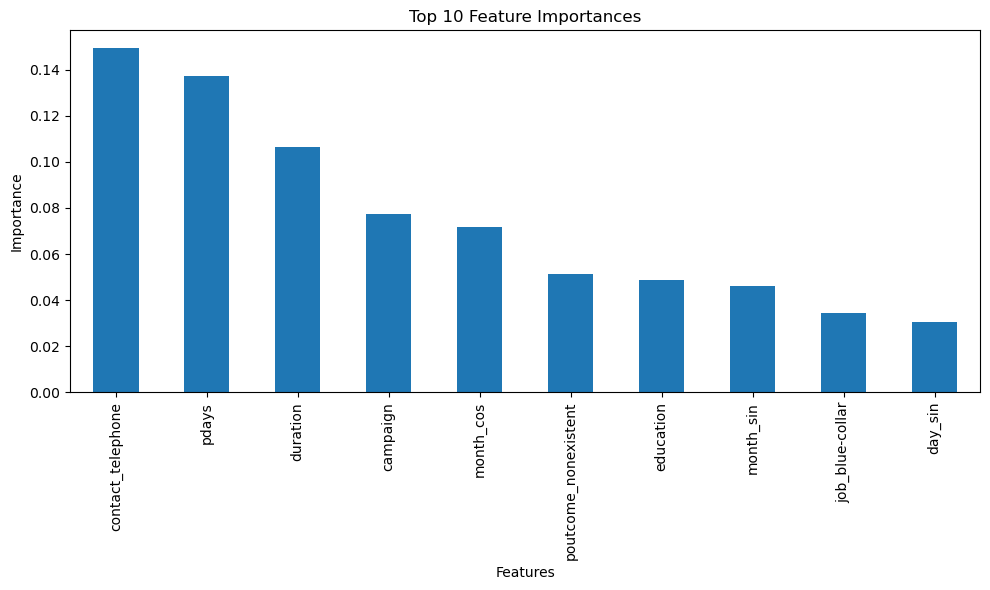

In [50]:
# Assuming 'grid_search' is your GridSearchCV object for Random Forest
best_rf = grid_search.best_estimator_

# Get feature names from your feature DataFrame
feature_names = feature.columns

# Calculate feature importances
feature_importances = pd.Series(best_rf.feature_importances_, index=feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)

print("Feature Importances:\n", sorted_importances)

# Optionally, you can visualize the top N features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_importances[:10].plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

The feature importance analysis using the tuned Random Forest model provides valuable insights into which variables most significantly influence the prediction of the target variable. The results highlight a shift in the importance of features compared to the previous analysis.

Contact_telephone has emerged as the most influential feature with an importance score of 0.149651, suggesting that the method of communication plays a crucial role in determining the outcome. This is followed closely by pdays (0.137454) and duration (0.106334), indicating that the recency of previous contact and the length of the interaction are critical factors.

The campaign feature (0.077288) and the cyclical representation of months (month_cos and month_sin) also show notable importance, underscoring the significance of marketing efforts and seasonal patterns in predicting outcomes.

Interestingly, poutcome_nonexistent (0.051450) and education (0.048849) have moderate importance, suggesting that the absence of previous marketing outcomes and the customer's educational background contribute meaningfully to the model's predictive power.

Job categories now appear lower in the importance ranking, with blue-collar jobs being the most important among them (0.034520). This indicates that while occupation provides some context, it's not as pivotal in predicting the target variable as other features.

Features like housing, loan, and age show relatively lower importance compared to the previous analysis, suggesting that these demographic factors, while still relevant, have less impact on the model's predictions after tuning.

The presence of both sine and cosine components for months and days (month_sin, month_cos, day_sin, day_cos) highlights the value of capturing cyclical trends in the data, although their importance varies.

Overall, this updated analysis reveals a more nuanced picture of feature importance, where communication methods, timing of interactions, and campaign-related factors play more significant roles than previously thought. This shift in feature importances provides valuable insights for refining marketing strategies and focusing on the most influential factors in predicting customer behavior.

2. How does incorporating cyclical encoding for time-related features (month and day of week) impact the classification performance for term deposit subscriptions?

In [51]:
# Use only cyclical features for this example
cyclical_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos']
X_cyclical = data_encoded[cyclical_features]

# Split the dataset into training and test sets
X_train_cyclical, X_test_cyclical, y_train_cyclical, y_test_cyclical = train_test_split(X_cyclical, target, test_size=0.2, random_state=42)

# Initialize and fit a Logistic Regression model
rf_model_cyclical = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_cyclical.fit(X_train_cyclical, y_train_cyclical)

# Evaluate accuracy on cyclical features
rf_preds_cyclical = rf_model_cyclical.predict(X_test_cyclical)
rf_accuracy_cyclical = accuracy_score(y_test, rf_preds_cyclical)

# Print results
print("Random Forest Accuracy with Cyclical Features Only:", rf_accuracy_cyclical)

Random Forest Accuracy with Cyclical Features Only: 0.8854452726559435


The analysis demonstrates that incorporating a comprehensive set of features significantly enhances the predictive performance of the Random Forest model compared to relying solely on cyclical features. Specifically, the model achieved an accuracy of 90.36% with all available features, surpassing the 88.54% accuracy obtained using only cyclical features. This indicates that non-cyclical features provide critical information that improves the model's ability to predict the target variable, `y`.

The results underscore the importance of leveraging a diverse set of features to capture the complexity of the data and enhance model performance. While cyclical features like `month` and `day_of_week` contribute valuable temporal insights, additional features such as job type, marital status, and contact method offer complementary information that strengthens predictive accuracy.

Moving forward, further optimization through feature selection and hyperparameter tuning could yield additional improvements. Understanding feature importance can also guide efforts to refine the model and ensure it captures the most relevant patterns in the data. By strategically combining various feature types and optimizing model parameters, we can achieve robust and reliable predictions tailored to our specific analytical goals.

usage: git [-v | --version] [-h | --help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [--config-env=<name>=<envvar>] <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone     Clone a repository into a new directory
   init      Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add       Add file contents to the index
   mv        Move or rename a file, a directory, or a symlink
   restore   Restore working tree files
   rm        Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect    Use binary search to find the commit that introduced 